In [16]:
!pip install -e .

Obtaining file:///C:/Users/rea095/Documents/livemaptiles
  Attempting uninstall: livemaptiles
    Found existing installation: livemaptiles 0.2.0
    Uninstalling livemaptiles-0.2.0:
      Successfully uninstalled livemaptiles-0.2.0
  Running setup.py develop for livemaptiles


Ive always wanted to be able to have a quick look at my large in memory spatial datasets while im writing code that uses them. just a quick check that things make sense is often all i need.
Plotting up a little image to show inline in a jupyter notebook seems to be the standard technology available but it just doesnt cut it. I end up dumping a copy to file and firing up a GIS for the easy pan/zoom/overlay/change symbology etc etc functionality. But that round trip is a pain.

some slippy maps that are interactive inside Jupyter would be nice.
seems others agree with projects like
- folium
- ipyleaflet (https://github.com/jupyter-widgets/ipyleaflet)
and others

they all seem to do a great job of adhoc looking at some vector data.

For raster things are limited.
one option is an imageoverlay -wont scale to a big dataset and i think it will have to hold the whole image in RAM seperatly to the copy you are working on. local tiles require writing all tiles out to disk

Introducing livemaptiles. 
- A tile service like any other tile service. Accessible from localhost and easy to be used in other tools like folium right in a Jupyter notebook.
- So simple to use just point it to a numpy array.
- since its only looking at a numpy array changes to the array appear in any newly rendered tiles straight away
- runs right in the jupyter notebook. No extra server set up.
- Uses the data you have in memory giving it a negligable memory footprint and makes it fast to produce tiles (dozens a second).
- change colour scheme and range on the fly

lets have a look


In [1]:
import livemaptiles
from matplotlib import cm
import rasterio

#2 example slippy map tools that work in a jupyter notebook
#you dont need both if you want to install less stuff.
import folium
import ipyleaflet as ipyl


when livemaptiles is imported it piggybacks a server onto Jupyter 

You can access the server in python as livemaptiles.tileServer or in a browser its found as 
```
http://localhost:8080/livemaptiles
```
It uses port 8080 by default but you can change that if you stop and restart the server

By default it exposes a set of tiles for debugging with a url in this format
```
http://localhost:8080/livemaptiles/debug/{z}/{x}/{y}.png
```

try (http://localhost:8080/livemaptiles/debug/0/0/0.png) for a rather boring tile.

additionally you can select a level of compression for the png file (compress0 to compress9) 0 is the default because its fastest and file size doesnt matter as the server is on the same computer.
```
http://localhost:8080/livemaptiles/debug/compress9/{z}/{x}/{y}.png
```
or you can use bmp files. These are fast and from what i can tell work well if you dont need transparancy
```
http://localhost:8080/livemaptiles/debug/{z}/{x}/{y}.bmp
```
By default the tiles are served with headers to tell the browser to not cache the tile. This means if you for example change the colour map being used the old tiles wont hand around as long. If you dont intend changing the tile source or rendering then you can tell the server to not include those headers and allow the browser to cache. ie put cache600 in the path after the layer name for a 600sec max age in the cache. It might speed things up if you are using code to make the tiles that takes a little while.
```
http://localhost:8080/livemaptiles/debug/cache600/compress9/{z}/{x}/{y}.png
```
If you want to get super fancy with async or multi threaded code to make the tiles then leaflet lets you use subdomains to get more tile requests in progress at once. We can simulate that on a localhost connection easily by using the local host ip address range like so.
```
http://127.0.0.{s}:8080/livemaptiles/debug/{z}/{x}/{y}.png
# dont forget to tell leaflet to use numeric subdomain substitution ie subdomains='123'
```

You can see the list of currently available layers by looking at the dictionary of layers in the tile server.

Each dictionary record has the name of the layer as a key and the function that makes the tiles as the value.



In [2]:
livemaptiles.tileServer.layers

{'debug': <function livemaptiles.debugTileMaker(layer, z, x, y)>}

In [3]:
#grab some example data using unusual gdal syntax
#This is a chunk of SRTM DEM data
#Note this will download a 26MB zipped file so might take a minute
#testFile = r'/vsizip/vsicurl/http://srtm.csi.cgiar.org/SRT-ZIP/SRTM_V41/SRTM_Data_GeoTiff/srtm_66_19.zip/srtm_66_19.tif'
#alternativly use a path to the file on your disk
testFile = r'/vsizip/srtm_66_19.zip/srtm_66_19.tif'
with rasterio.open(testFile) as src:
    #rasterio reads this as a 3d array but since there is only one band slice it to a 2d array.
    in_array = src.read()[0]
    in_affine = src.transform
    in_crs = src.crs

In [4]:
#have a look at some basic data information - 
print (in_array.dtype)
print (in_array.shape)
print (in_array.min(), in_array.max())
print (in_crs)
print (in_affine)
print ('cellsize',in_affine.a)

int16
(6001, 6001)
75 1390
EPSG:4326
| 0.00, 0.00, 145.00|
| 0.00,-0.00,-30.00|
| 0.00, 0.00, 1.00|
cellsize 0.0008333333333333334


In [5]:
at = livemaptiles.arrayTile(in_array,in_affine,in_crs)
at.scale_min = 100
at.scale_max = 1200
at.colourMap = cm.viridis
livemaptiles.tileServer.layers['array2tile'] = at.tileMaker

In the above we set up the arrayTile object then told the tileServer to use its TileMaker function to produce tiles.

The tileMaker function just returns PIL images that are 256 x 256 pixels. You can make your own. arrayTile is one I made that works on numpy 2d arrays and handles projections,colourmaps etc.
The server requests the image from the tileMaker with arguments of (layer,z,x,y) 

Now lets test the tileMaker without the server to see that it works and is fast. You dont neeed to do this its just for demonstration.

In [6]:
#making the tile is quick
%timeit at.tileMaker("",8,234,153)
#things are a bit slower when the server converts to an optimally compressed png file
%timeit livemaptiles.PIL_image_in_bytes(at.tileMaker("",8,234,153),'png',9)
#since the tile isnt going over the internet we can not compress to save time
%timeit livemaptiles.PIL_image_in_bytes(at.tileMaker("",8,234,153)) #png with no compression is the default
#even quicker is to use a bmp file rather then a png. In testing leaflet on chrome has no issue with these. Note that there is no transparancy in a bmp image
%timeit livemaptiles.PIL_image_in_bytes(at.tileMaker("",8,234,153),'bmp')

21 ms ± 993 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
72.3 ms ± 5.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.8 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.6 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


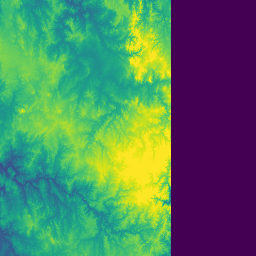

In [7]:
#a single tile for demonstration
at.tileMaker("",8,234,153)

There is nothing to stop you changing the way the data is rendered even while the server is live. Infact you can even change the values in the numpy array or even give arrayTile a different array to use.

In [13]:
at.scale_min = 1
at.colourMap = cm.autumn
at.colourMap.set_under(alpha=0)


In [10]:
# you can use this to play around with a large array if you have RAM to spare
#bob = np.random.randint(1,300,(50000,5000))
#at.in_array = bob
#at.in_affine = rasterio.transform.from_origin(0,0,0.01,0.01)

Now lets try with ipyleaflet.

In [12]:
t = ipyl.TileLayer(
            url = 'http://localhost:8080/livemaptiles/array2tile/{z}/{x}/{y}.png',
            attribution = 'test attribution')
m = ipyl.Map(center=[-35.0, 148.0], zoom=8)
m.add_layer(t)
m.scroll_wheel_zoom = True
m.layout.height = '500px'
m

Map(center=[-35.0, 148.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [10]:
#change the tile layer rendering.
at.scale_min = 1
at.scale_max = 500
at.colourMap = cm.gist_earth
at.colourMap.set_under(alpha=0)
#ipyleaflet nicely allows you to trigger a refetch of all the tiles with redraw
t.redraw()

There is also a couple of other tile makers implemented but they have a few issues.

They are based on rasterio/gdal and with a bit of work they might be good for some other use cases so Ive left them in as examples. 
```
livemaptiles.fileTile('path to file on disk').tileMaker
livemaptiles.memfileTile(in_array,in_affine,in_crs).tileMaker
```

